# **Preet Parmar** #
# 780-215-3434 -- preet@ualberta.ca #

# Introduction #

This Notebook will analyze City of Toronto Parking Infraction Data.

# Data Cleaning + Manipulation #

Data was acquired from the open.toronto website. All data was downloaded and placed in a folder named *parking_data*. For some files, I had to use Notepad++ to change the encoding to UTF8 otherwise I would get an error. This was about all the external manipulation I did. Then I exported the giant dataset for analysis.

In [ ]:
import glob           #importing modules to manipulate data files
import pandas as pd
import os

# get data file names
path =r'C:\Users\Preet\Downloads\parking_data'
filenames = glob.glob(path + "/*.csv")

#load in all files and put in one dataframe
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename,error_bad_lines=False,dtype={'time_of_infraction': 'float64'},engine='python'))
   

 #make big dataset
data = pd.concat(dfs, ignore_index=True)

In [104]:
data.to_csv('Parking_Tags_Data.csv',encoding='utf-8')

# Getting Some Insights #
For this section, I used dask for parallel computing since the dataset contains millions of rows and we need a scalable alternative to pandas. Then I ran a few operations on it to extract some insights. 

In [2]:
import pandas as pd              #import data analysis libraries
from dask import dataframe as dd

dfd = dd.read_csv('C:/Users/Preet/Downloads/parking_data/Parking_Tags_Data.csv',   
                  dtype={'time_of_infraction': 'float64'},
                 blocksize=64000000)   #setting up the dask dataframe

top_infractions_dask = dfd['infraction_description'].value_counts().nlargest(20) #extracting top 20 infractions

The top 20 parking infractions overall are below. Interestingly, Parking at a prohibited time without a permit is 1st by a longshot, 4.3 million incidences. Then it tapers off to some other common occurences, before dropping much more from parking on private property to not paying a parking meter.

In [106]:
top_infractions_dask.compute() #computing

PARK PROHIBITED TIME NO PERMIT    4339204
PARK FAIL TO DISPLAY RECEIPT      2823749
PARK HWY PROHIBED TIME/DAY        2272075
PARK/LEAVE ON PRIVATE PROPERTY    2237439
PARK-SIGNED HWY-PROHIBIT DY/TM    1918237
PARK FAIL TO DEP. FEE MACHINE     1580898
PARK ON PRIVATE PROPERTY          1518834
PARK MACHINE-REQD FEE NOT PAID     690284
STOP HWY PROHIBITED TIME/DAY       632436
PARK-HWY DRNG PROH TIMES/DAYS      607304
STOP-SIGNED HWY-PROHIBIT TM/DY     526890
PARK LONGER THAN 3 HOURS           503409
PARK HWY IN EXCESS PRMTD TIME      461273
STD VEH HWY PROHIB TIME/DAY        413032
PARK-VEH. W/O VALID ONT PLATE      388901
STAND VEH.-PROHIBIT TIME/DAY       387041
STOP-HWY-PROHIBITED TIMES/DAYS     374613
STOP-SIGNED HIGHWAY-RUSH HOUR      348850
PARK - LONGER THAN 3 HOURS         331020
PARK-SIGNED HWY-EXC PERMT TIME     321975
Name: infraction_description, dtype: int64

Top revenue generating parking infractions are below. The number one incidence is not surprising, as it is also the number 1 infraction by far. Varying ticket prices for parking infractions would explain the other variations between the two lists so far.

In [152]:
top_revenue_dask = dfd.groupby(['infraction_description'])['set_fine_amount'].sum() 
top_revenue_dask_ = top_revenue_dask.compute().sort_values(ascending=False).nlargest(20)
top_revenue_dask_ #computing the top revenue generating parking infractions

infraction_description
PARK PROHIBITED TIME NO PERMIT    130176120
PARK HWY PROHIBED TIME/DAY         88639690
PARK-SIGNED HWY-PROHIBIT DY/TM     87022370
PARK FAIL TO DISPLAY RECEIPT       84712470
PARK/LEAVE ON PRIVATE PROPERTY     67123170
PARK IN A FIRE ROUTE               58521250
STOP-SIGNED HIGHWAY-RUSH HOUR      52327500
PARK FAIL TO DEP. FEE MACHINE      47426940
PARK ON PRIVATE PROPERTY           45565020
STOP HWY PROHIBITED TIME/DAY       37946160
STOP-SIGNED HWY-PROHIBIT TM/DY     31613400
STD VEH HWY PROHIB TIME/DAY        24781920
PARK-HWY DRNG PROH TIMES/DAYS      23684370
STAND VEH.-PROHIBIT TIME/DAY       23222460
STOP-HWY-PROHIBITED TIMES/DAYS     22471140
PARK MACHINE-REQD FEE NOT PAID     20708520
STAND SIGNED TRANSIT STOP          20167800
PARK 3M OF FIRE HYDRANT            18873120
PARK-WITHIN 3M OF FIRE HYDRANT     16605900
PARK-VEH. W/O VALID ONT PLATE      15556040
Name: set_fine_amount, dtype: int64

Total revenue generated from all parking infractions is about 1.3 billion dollars in the last 10 years! That is quite a lot of money from parking tickets.

In [120]:
top_revenue_dask.compute().sum() #computing total revenue

1193164310

Next, we compute the top locations where parking infractions occured over the last 10 years. It appears 2075 Bayview Ave is a notorious spot for getting a parking ticket -- lots of perpetrators in that area!

In [150]:
top_locations_dask = dfd['location2'].value_counts().nlargest(20)
a = top_locations_dask.compute()
print(a)

2075 BAYVIEW AVE        67723
20 EDWARD ST            66649
1750 FINCH AVE E        48447
JAMES ST                34870
2075 BAYVIEW AV         34323
40 ORCHARD VIEW BLVD    24156
25 ST MARY ST           23977
25 THE WEST MALL        23783
3401 DUFFERIN ST        23623
70 YORK ST              22407
LA PLANTE AVE           22095
60 BLOOR ST W           21585
2 COOPER ST             21525
225 KING ST W           21485
74 VICTORIA ST          21324
110 ELM ST              19809
200 KING ST E           19468
150 YORK ST             19398
15 ASQUITH AVE          19201
200 ELIZABETH ST        19045
Name: location2, dtype: int64


# Finding Out Where it Happened #

Another piece to the story is getting to the bottom of where people actually parked. It helps to know how close infractions were to parking lots and ttc stops -- maybe lots of people tried to pull off a free 'park and ride' or couldn't find a parking spot in a lot, and parked in an unauthorized area.

In [7]:
import requests       #importing packages to get latitude/longitude data from street addresses.
import urllib.parse
import numpy as np

lat=[]
lon=[]
for address in a.index:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address+', Toronto') + '?format=json'
    response = requests.get(url).json()
    lat.append(response[0]["lat"])
    lon.append(response[0]["lon"]) #getting latitude/longitude from nominatim api so we can use it in our analysis

latlon = pd.DataFrame({'lat':lat, 'lon':lon}) #latitude/longitude dataframe
print(latlon)

                   lat                 lon
0          43.72285855  -79.37566139839973
1    43.65694125806451  -79.38206729032258
2           43.7937915         -79.3503082
3           43.5897222         -79.5423804
4          43.72285855  -79.37566139839973
5           43.7083798         -79.4000683
6          43.66733945   -79.3872088302951
7          43.61188875  -79.55777331532131
8           43.7256238  -79.45230789320112
9           43.6467492         -79.3832611
10          43.6591927         -79.3860233
11           43.670135          -79.389429
12         43.64298895  -79.37258807185887
13          43.6466217          -79.388501
14          43.6512911         -79.3777824
15          43.6563019         -79.3891028
16         43.65131275  -79.37024696402364
17          43.6495789         -79.3845764
18          43.6716346         -79.3848029
19  43.658587600000004  -79.38815803478147


In [ ]:
import json  #importing json package

f = open('green-p-parking-2019.json',) #opening file for parking lot data

data = json.load(f)                 #getting carpark latitude/longitude data from dataset
data = pd.DataFrame.from_dict(data)
data = data['carparks'].apply(pd.Series)

greenp = pd.DataFrame({'lat':data['lat'],'lon':data['lng']}) #we have our dataframe

Looks like most of the top 20 infractions were within 500m of the nearest parking lot! That's interesting, because it tells us infractions often occur near parking lots.

In [18]:
import geopy.distance #good method for calculating distance between coordinates

compare=[]       #this is some automation I designed for comparing distance from one spot to 
distance=[]      #all parking lots, then taking the distance to the closest parking lot and moving on to the next
for i in range(len(latlon)):     #address.
    coord1 = (latlon['lat'][i],latlon['lon'][i])   
    for j in range(len(greenp)):  
        coord2 = (greenp['lat'][j],greenp['lon'][j])
        compare.append(geopy.distance.distance(coord1,coord2).km)
        
    distance.append(min(compare))
    compare = []
    

distance = pd.Series(distance) #finally we print out the table 
b = pd.DataFrame(a)
b.reset_index(level=0,inplace=True)
b['Distance'] = distance
b.columns=['Address','Infractions','Distance (km)']
print('Distance to closest Parking Lots for top 20 Infraction Locations')
b

Distance to closest Parking Lots for top 20 Infraction Locations


,Address,Infractions,Distance (km)
0,2075 BAYVIEW AVE,67723,0.334659
1,20 EDWARD ST,66649,0.201211
2,1750 FINCH AVE E,48447,2.018260
3,JAMES ST,34870,1.854198
4,2075 BAYVIEW AV,34323,0.334659
5,40 ORCHARD VIEW BLVD,24156,0.184310
6,25 ST MARY ST,23977,0.203498
7,25 THE WEST MALL,23783,3.341619
8,3401 DUFFERIN ST,23623,0.913269
9,70 YORK ST,22407,0.141616


Top 20 infractions were also very close to ttc stops as shown in the following table. 

In [19]:
stops = pd.read_csv('stops.txt')        #importing ttc stop data
stopdata = pd.DataFrame({'lat':stops['stop_lat'],'lon':stops['stop_lon']})

compare=[]
distance=[]       #same loop from before, this time comparing to the nearest ttc stop distance
for i in range(len(latlon)):
    coord1 = (latlon['lat'][i],latlon['lon'][i])   
    for j in range(len(greenp)):  
        coord2 = (stopdata['lat'][j],stopdata['lon'][j])
        compare.append(geopy.distance.distance(coord1,coord2).km)
        
    distance.append(min(compare))
    compare = []
    
distance = pd.Series(distance)    #finally printing out the table.
c = pd.DataFrame(a)
c.reset_index(level=0,inplace=True)
c['Distance'] = distance
c.columns=['Address','Infractions','Distance (km)']
print('Distance to closest TTC stops for top 20 Infraction Locations')
c

Distance to closest TTC stops for top 20 Infraction Locations


,Address,Infractions,Distance (km)
0,2075 BAYVIEW AVE,67723,0.339090
1,20 EDWARD ST,66649,1.184089
2,1750 FINCH AVE E,48447,0.754044
3,JAMES ST,34870,0.286000
4,2075 BAYVIEW AV,34323,0.339090
5,40 ORCHARD VIEW BLVD,24156,0.238878
6,25 ST MARY ST,23977,0.397296
7,25 THE WEST MALL,23783,0.210409
8,3401 DUFFERIN ST,23623,0.382256
9,70 YORK ST,22407,0.391509


# Impact of Time on Parking Infractions #

Could time possibly have something to do with the frequency of parking infractions throughout the last 10 years? Lets try to find out. First we're going to look at the most common day infractions happen.

In [ ]:
from datetime import datetime     #importing time packages 
import calendar
import time

day_of_week_dask = dfd['date_of_infraction'].apply(str, meta=('date_of_infraction', 'object')) 
f = []   #used dask to get the dates of all infractions, then changed the date strings to datetime objects after
for day in day_of_week_dask:     #converting the format into something datetime can read
    day = datetime.strptime(day,'%Y%m%d').strftime('%Y-%m-%d') #then we extract the weekday.
    day = pd.to_datetime(day)
    f.append(day.weekday())

We see that Tuesdays to Fridays are the most common days when parking infractions occur. This is followed by a drop off on Mondays, and Sundays are the day where parking infractions are least frequent overall. The first hypothesis for me is that people have to work on weekdays as opposed to weekends. Therefore, less people park on the weekend. As well, my hunch is that people dont tend to park in the city over the weekend, and if they do, they remember to move their car on Monday, otherwise they'd get a ticket. Next up, lets see how parking infractions vary by month of year.

In [79]:
f = pd.Series(f)    #printing out a table of the days where parking infractions are frequent.
h = f.value_counts()
h.index = ['Tue','Fri','Thu','Wed','Mon','Sat','Sun']
h = pd.DataFrame(h)
h.columns = ['Infractions']
h

,Infractions
Tue,4298308
Fri,4298052
Thu,4295755
Wed,4281998
Mon,3794105
Sat,3768590
Sun,2919876


In [23]:
g = []   #same loop as before, but this time for the month of the year.
for day in day_of_week_dask:
    day = datetime.strptime(day,'%Y%m%d').strftime('%Y-%m-%d')
    day = pd.to_datetime(day)
    g.append(day.month)

Ah, interesting! February and December are the least common months for parking infractions. But, wait a minute! February only has 28 days (29 on leap years). Therefore, February is lower because there are less days in that month. However, December is definitely lower for a reason -- winter holidays. During the holidays, not many people will be in town, and if they are, their cars will be at home.

In [186]:
g = pd.Series(g) #constructing the table for month of year parking infractions are common
i = g.value_counts()
i.index=['Mar','May','Jun','Apr','Oct','Nov','Aug','Jul','Sep','Jan','Feb','Dec']
i = pd.DataFrame(i)
i.columns = ['Infractions']
i

,Infractions
Mar,2482780
May,2453236
Jun,2383460
Apr,2383277
Oct,2382692
Nov,2311986
Aug,2304302
Jul,2298606
Sep,2295007
Jan,2232724


Now let's look at the seasons. It looks like parking infractions drop off a little bit in the Fall, and then pick back up in the winter time. This is in line with our investigation of the months.

In [185]:
#Meteorogical Seasons 
Seasons = pd.Series([i[11]+i[0:1].sum(),i[2:4].sum(),i[5:7].sum(),i[8:10].sum()])
Seasons.index = ['Winter','Spring','Summer','Fall']
Seasons = pd.DataFrame(Seasons)
Seasons.columns=['Infractions']
print('Infractions by Season')
Seasons

Infractions by Season


,Infractions
Winter,4794766
Spring,4766737
Summer,4616288
Fall,4527731


In [80]:
j = []       #Same loop as before, but for years. We can see what happened to parking infractions over the years.
for day in day_of_week_dask:
    day = datetime.strptime(day,'%Y%m%d').strftime('%Y-%m-%d')
    day = pd.to_datetime(day)
    j.append(day.year)

Looking at the years, it seems that frequency of parking infractions is slowly decreasing as time goes on. Good job, Torontonians! 

In [85]:
j = pd.Series(j) #constructing the table.
k = j.value_counts()
k = pd.DataFrame(k)
k.columns = ['Infractions']
k

,Infractions
2008,2866860
2011,2805492
2009,2772975
2010,2756878
2012,2746154
2013,2611575
2014,2484983
2016,2254761
2015,2168493
2017,2144225


In [137]:
compression_opts = dict(method='zip', archive_name='out.csv') #this is just a checkpoint. I saved the tables
                                                              #incase anything happened
h.to_csv('h.zip',compression=compression_opts)
i.to_csv('i.zip',compression=compression_opts)
k.to_csv('j.zip',compression=compression_opts)

# Visualizations #

For any analysis, it's important to actually see what's going on with our data. In this section we'll plot some charts so we can look at how parking infractions are affected by certain things.

First let's have a closer look at how parking infractions are affected by time. As shown in the graph below, they have been steadily decreasing after ~2011 or so. 

C:\Users\Preet\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

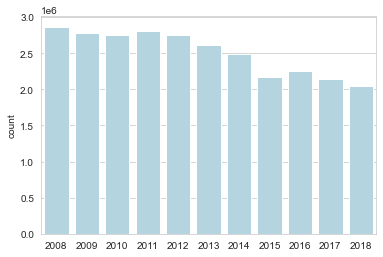

In [135]:
import seaborn as sns        #plotting the graph of parking infractions as a function of time.
sns.set_style('whitegrid')
sns.countplot(j,color='lightblue')

Below is a graph of parking infractions by month. The y axis represents months from 1 - January to 12 - December. As we said earlier, December and February are the months where parking infractions happen least often, but February is because it's a shorter month, and December is because there are holidays.

<AxesSubplot:xlabel='count'>

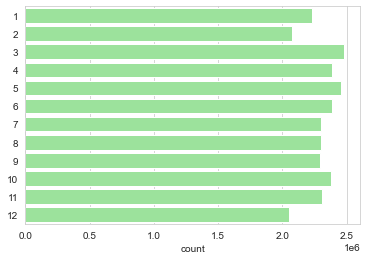

In [149]:
sns.countplot(y=g.index,data=g,color='lightgreen') #plotting parking infractions by month

Below there is a graph of parking infractions by revenue. We see that parking at a prohibited time without a permit is way ahead of the rest of the pack. 

<AxesSubplot:xlabel='set_fine_amount', ylabel='infraction_description'>

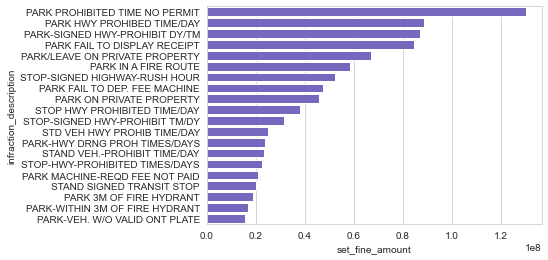

In [177]:
top_revenue_dask_ = pd.DataFrame(top_revenue_dask_) #graphing parking infractions by revenue
top_revenue_dask_
sns.barplot(x='set_fine_amount',y=top_revenue_dask_.index,data=top_revenue_dask_,color='slateblue')

# Geographical Plotting #

So we've seen how time impacts parking infractions, but let's go further in investigating the location of infractions in Toronto. Some of the code in here is repeated because I performed it in another notebook in a geopandas environment.

In [67]:
import geopandas as gpd    #importing geopandas and matplotlib graphing packages
import matplotlib.pyplot as plt

In [2]:
import pandas as pd 


dfd = pd.read_csv('C:/Users/Preet/Downloads/parking_data/Parking_Tags_Data.csv',
                  dtype={'time_of_infraction': 'float64'})

top_infractions_dask = dfd['infraction_description'].value_counts().nlargest(20) #some computations performed earlier

In [3]:
top_locations_dask = dfd['location2'].value_counts().nlargest(20) #computing top infractions by location
a = top_locations_dask
print(a)

2075 BAYVIEW AVE        67723
20 EDWARD ST            66649
1750 FINCH AVE E        48447
JAMES ST                34870
2075 BAYVIEW AV         34323
40 ORCHARD VIEW BLVD    24156
25 ST MARY ST           23977
25 THE WEST MALL        23783
3401 DUFFERIN ST        23623
70 YORK ST              22407
LA PLANTE AVE           22095
60 BLOOR ST W           21585
2 COOPER ST             21525
225 KING ST W           21485
74 VICTORIA ST          21324
110 ELM ST              19809
200 KING ST E           19468
150 YORK ST             19398
15 ASQUITH AVE          19201
200 ELIZABETH ST        19045
Name: location2, dtype: int64


In [4]:
import requests          #Getting latitude/longitude matrix again.
import urllib.parse
import numpy as np

lat=[]
lon=[]
for address in a.index:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address+', Toronto') + '?format=json'
    response = requests.get(url).json()
    lat.append(response[0]["lat"])
    lon.append(response[0]["lon"])

latlon = pd.DataFrame({'lat':lat, 'lon':lon})
print(latlon)

                   lat                 lon
0          43.72285855  -79.37566139839973
1    43.65694125806451  -79.38206729032258
2           43.7937915         -79.3503082
3           43.5897222         -79.5423804
4          43.72285855  -79.37566139839973
5           43.7083798         -79.4000683
6          43.66733945   -79.3872088302951
7          43.61188875  -79.55777331532131
8           43.7256238  -79.45230789320112
9           43.6467492         -79.3832611
10          43.6591927         -79.3860233
11           43.670135          -79.389429
12         43.64298895  -79.37258807185887
13          43.6466217          -79.388501
14          43.6512911         -79.3777824
15          43.6563019         -79.3891028
16         43.65131275  -79.37024696402364
17          43.6495789         -79.3845764
18          43.6716346         -79.3848029
19  43.658587600000004  -79.38815803478147


Finally, we have mapped the locations of the top 20 infractions below! It looks like a large concentration of them happen in the inner city, with a few interspersed in the outskirts.

Text(0.5, 1.0, 'Top 20 Infraction Locations in the City of Toronto')

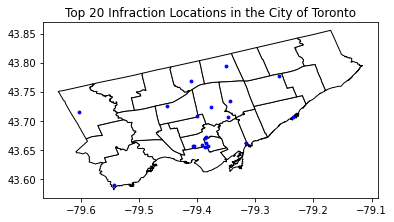

In [71]:
lo=latlon['lon']
la=latlon['lat']      #Here we are mapping where infractions actually happened. 

gdf = gpd.GeoDataFrame(latlon, geometry=gpd.points_from_xy(lo,la))

toronto_map = gpd.read_file(r'C:\Users\Preet\Downloads\parking_data\City Wards Data\City Wards Data.shp')
ax = toronto_map.plot(color='white',edgecolor='black')     #setting up geopandas dataframe and plotting it
gdf.plot(ax=ax, color='blue',markersize=8)
plt.title('Top 20 Infraction Locations in the City of Toronto')

Now we are plotting by concentration of parking infractions by ward. We see that the wards in the inner city have more of a concentration of infractions than outside, with none of the top 20 appearing in wards located on the outskirts of the city. It looks like the inner city is a hotspot for parking infractions.

Text(0.5, 1.0, 'Top 20 Infractions by Ward in the City of Toronto')

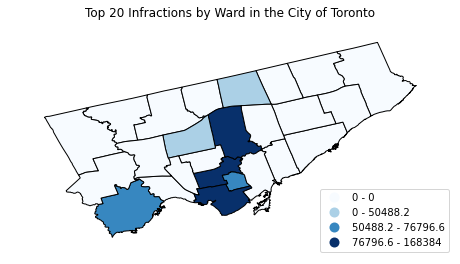

In [69]:
import warnings             #ignoring warnings that are output when I graph 
warnings.filterwarnings('ignore')
data_poly = gpd.read_file(r"C:\Users\Preet\Downloads\parking_data\City Wards Data.geojson") #importing and 
latlon['Address'] = a.index                                                                 #manipulating geodata
gdf2 = gpd.GeoDataFrame(latlon,geometry=gpd.points_from_xy(latlon.lon,latlon.lat))
joined_gdf = gpd.sjoin(gdf2, data_poly, op='within') #joining geodata dataframes so I can find which datapoints
                                                     #to bin into each ward.
toronto_map = gpd.read_file(r'C:\Users\Preet\Downloads\parking_data\City Wards Data\City Wards Data.shp')
import mapclassify    #importing more geopackages.
import geoplot
count = [0,0,0,66649+22095+21585+19809+19201+19045,0,0,0,0,0,0,0,67723+34323,0,0,0,34870+23783,0,24156+23623,48447,0,0,23977+21324+19468,0,0,19398+22407+21525+21485]
scheme = mapclassify.Quantiles(count,k=10)    #graphing with frequency of parking infractions as a scale for 
geoplot.choropleth(toronto_map,hue=count,scheme=scheme,cmap='Blues',legend=True) #color in the plot
plt.title('Top 20 Infractions by Ward in the City of Toronto')

In [61]:
top_revenue_ward = dfd.groupby(['location2'])['set_fine_amount'].sum()   #computing top revenue by location
top_revenue_ward = top_revenue_dask.sort_values(ascending=False).nlargest(20)
b = top_revenue_ward

lat=[]    #same loop as before, generating latitude/longitudes
lon=[]
for address in b.index:
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address+', Toronto') + '?format=json'
    response = requests.get(url).json()
    lat.append(response[0]["lat"])
    lon.append(response[0]["lon"])

latlon = pd.DataFrame({'lat':lat, 'lon':lon})


import warnings
warnings.filterwarnings('ignore')   #graphing again but this time with respect to revenue per location
data_poly = gpd.read_file(r"C:\Users\Preet\Downloads\parking_data\City Wards Data.geojson")
latlon['Address'] = b.index
gdf2 = gpd.GeoDataFrame(latlon,geometry=gpd.points_from_xy(latlon.lon,latlon.lat))
joined_gdf = gpd.sjoin(gdf2, data_poly, op='within')

toronto_map = gpd.read_file(r'C:\Users\Preet\Downloads\parking_data\City Wards Data\City Wards Data.shp')

Next we make a heatmap of top 20 infraction locations with respect to revenue by ward. It looks like revenue is generated in more wards, but like before, the highest revenue is concentrated in the inner city. However, we have more variance here across wards, where there is more of a distribution of how much is made.

Text(0.5, 1.0, 'Best Revenue-generating Wards for Top 20 Infraction Locations in the City of Toronto')

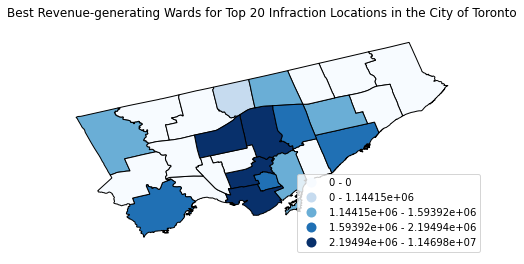

In [82]:
import mapclassify  #setting up the actual graph and associating revenue with wards.
import geoplot
count = [0,0,1144150,3227670+2660880+1978105+1318305+1177310+1107510,0,2194935,0,0,0,1354540,0,2039625+1285565,0,0,1423480,1953625,0,2722070+1834700,1593925,1912070,0,1989190,0,1150730,2457716]
scheme = mapclassify.Quantiles(count,k=6)
geoplot.choropleth(toronto_map,hue=count,scheme=scheme,cmap='Blues',legend=True)
plt.title('Best Revenue-generating Wards for Top 20 Infraction Locations in the City of Toronto')


# Interesting Demographic Indicators #

I couldn't seem to download data from the Wellbeing Toronto website -- it kept giving me an error when I tried to download csv's. However, I have included an image that I captured of the "attraction" figures under the recreation section, which similarly lines up with parking infractions. My hypothesis for this section is that more people do things in the inner city, such as working, recreation, tourism, etc. such that there will be more infractions concentrated in that area. Toronto proper has a large concentration of attractions as I found on the website.

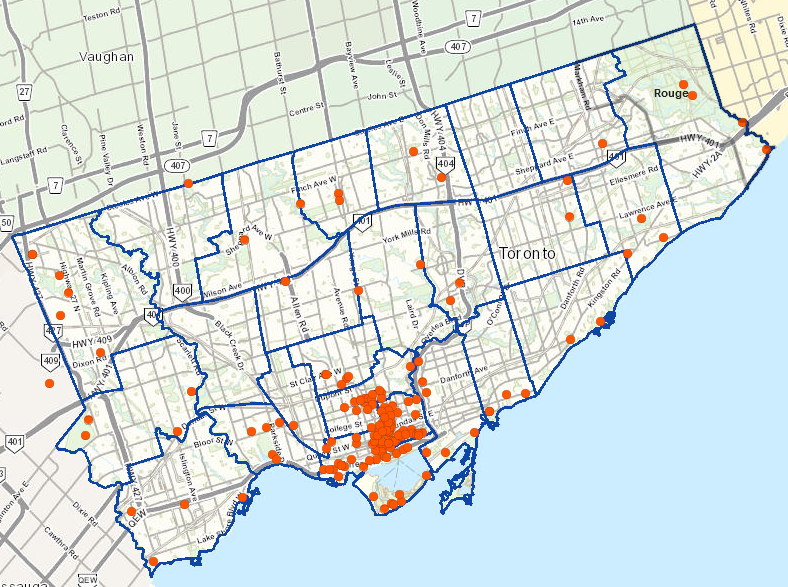

In [83]:
from IPython.display import Image
Image(filename='Capture.png')